# Tang Band W3-871SC Midrange Driver - Design Calculations

This notebook serves as the **source of truth** for the Tang Band W3-871SC midrange driver design. All calculations are based on measured data and first principles, with the results driving the physical implementation.

## Core Principles
1. **Calculations Drive Design**: Parameters calculated here define the build, not validate it
2. **Measurement-Based**: Using real impedance and frequency response measurements
3. **Show Your Work**: All mathematical reasoning is displayed
4. **Compare Alternatives**: Multiple design options with trade-offs
5. **Practical Warnings**: Clear indication when preferences conflict with optimal calculations

## Driver Overview
- **Model**: Tang Band W3-871SC
- **Type**: 3" full-range driver (used as midrange)
- **Configuration**: Sealed enclosure
- **Frequency Range**: 200-2750 Hz in 3-way system

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 1. Driver Parameter Analysis - From Measurements

First, we'll analyze the real measurement data to extract the true T/S parameters and compare them with manufacturer specifications.

In [ ]:
# Load and analyze measurement data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy.interpolate import interp1d
import json
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Load real measurement data
try:
    fr_data = pd.read_csv('../speakers/TangBand W3-871SC/Frequency Response.csv', 
                         header=None, names=['freq', 'spl'])
    impedance_data = pd.read_csv('../speakers/TangBand W3-871SC/Impedance.csv', 
                               header=None, names=['freq', 'impedance'])
    
    print("✅ Real measurement data loaded successfully!")
    print(f"Frequency response: {len(fr_data)} points from {fr_data['freq'].min():.0f} to {fr_data['freq'].max():.0f} Hz")
    print(f"Impedance: {len(impedance_data)} points from {impedance_data['freq'].min():.0f} to {impedance_data['freq'].max():.0f} Hz")
    
    real_data_available = True
except FileNotFoundError:
    print("❌ Real measurement data not found - cannot proceed with calculations")
    print("This notebook requires actual measurement data to generate accurate parameters")
    real_data_available = False

# Extract T/S parameters from impedance measurement
def extract_ts_parameters(impedance_data):
    """Extract Thiele-Small parameters from impedance measurements"""
    # Find resonance frequency (peak impedance)
    fs_idx = impedance_data['impedance'].idxmax()
    fs_measured = impedance_data.loc[fs_idx, 'freq']
    zmax = impedance_data.loc[fs_idx, 'impedance']
    
    # Find DC resistance (minimum impedance above DC)
    re_region = impedance_data[impedance_data['freq'] < fs_measured * 0.5]
    if len(re_region) > 0:
        re_measured = re_region['impedance'].min()
    else:
        re_measured = impedance_data['impedance'].min()
    
    # Calculate r0 (impedance ratio)
    r0 = zmax / re_measured
    
    # Find -3dB frequencies for Qes calculation
    z_3db = re_measured * np.sqrt(r0)
    
    # Find frequencies where impedance crosses z_3db
    below_fs = impedance_data[impedance_data['freq'] < fs_measured]
    above_fs = impedance_data[impedance_data['freq'] > fs_measured]
    
    # Interpolate to find exact crossing points
    f1_idx = np.where(below_fs['impedance'] >= z_3db)[0]
    if len(f1_idx) > 0:
        f1_idx = f1_idx[-1]
        f1 = below_fs.iloc[f1_idx]['freq']
    else:
        f1 = fs_measured * 0.7  # Estimate if not found
    
    f2_idx = np.where(above_fs['impedance'] >= z_3db)[0]
    if len(f2_idx) > 0:
        f2_idx = f2_idx[0]
        f2 = above_fs.iloc[f2_idx]['freq']
    else:
        f2 = fs_measured * 1.3  # Estimate if not found
    
    # Calculate Q factors
    qms_measured = fs_measured * np.sqrt(r0) / (f2 - f1)
    qes_measured = qms_measured / (r0 - 1)
    qts_measured = (qms_measured * qes_measured) / (qms_measured + qes_measured)
    
    return {
        'fs_measured': fs_measured,
        're_measured': re_measured,
        'zmax': zmax,
        'r0': r0,
        'f1': f1,
        'f2': f2,
        'qms_measured': qms_measured,
        'qes_measured': qes_measured,
        'qts_measured': qts_measured
    }

# Manufacturer specifications for comparison
mfr_specs = {
    'fs': 110,      # Hz
    're': 6.6,      # Ω
    'qts': 0.59,
    'qms': 3.40,
    'qes': 0.71,
    'vas': 1.65,    # L
    'bl': 3.51,     # Tm
    'sd': 32e-4,    # m²
    'xmax': 0.5e-3, # m
    'sensitivity': 86.0  # dB @ 2.83V/1m
}

if real_data_available:
    # Extract measured parameters
    measured_params = extract_ts_parameters(impedance_data)
    
    # Display comparison table
    comparison_data = [
        ['Parameter', 'Manufacturer', 'Measured', 'Difference', 'Status'],
        ['Fs (Hz)', f"{mfr_specs['fs']}", f"{measured_params['fs_measured']:.1f}", 
         f"{abs(measured_params['fs_measured'] - mfr_specs['fs']):.1f} Hz", 
         '✅' if abs(measured_params['fs_measured'] - mfr_specs['fs']) < 10 else '⚠️'],
        ['Re (Ω)', f"{mfr_specs['re']}", f"{measured_params['re_measured']:.2f}", 
         f"{abs(measured_params['re_measured'] - mfr_specs['re']):.2f} Ω",
         '✅' if abs(measured_params['re_measured'] - mfr_specs['re']) < 0.5 else '⚠️'],
        ['Qts', f"{mfr_specs['qts']}", f"{measured_params['qts_measured']:.3f}",
         f"{abs(measured_params['qts_measured'] - mfr_specs['qts']):.3f}",
         '✅' if abs(measured_params['qts_measured'] - mfr_specs['qts']) < 0.1 else '⚠️'],
        ['Qms', f"{mfr_specs['qms']}", f"{measured_params['qms_measured']:.2f}",
         f"{abs(measured_params['qms_measured'] - mfr_specs['qms']):.2f}",
         '✅' if abs(measured_params['qms_measured'] - mfr_specs['qms']) < 0.5 else '⚠️'],
        ['Qes', f"{mfr_specs['qes']}", f"{measured_params['qes_measured']:.3f}",
         f"{abs(measured_params['qes_measured'] - mfr_specs['qes']):.3f}",
         '✅' if abs(measured_params['qes_measured'] - mfr_specs['qes']) < 0.1 else '⚠️']
    ]
    
    print("\n📊 T/S PARAMETER COMPARISON:")
    print("=" * 75)
    for row in comparison_data:
        if row[0] == 'Parameter':
            print(f"{row[0]:<15} {row[1]:<15} {row[2]:<15} {row[3]:<15} {row[4]}")
            print("-" * 75)
        else:
            print(f"{row[0]:<15} {row[1]:<15} {row[2]:<15} {row[3]:<15} {row[4]}")
    
    print(f"\n📈 MEASURED IMPEDANCE CHARACTERISTICS:")
    print(f"   • Peak impedance (Zmax): {measured_params['zmax']:.1f} Ω")
    print(f"   • Impedance ratio (r0): {measured_params['r0']:.2f}")
    print(f"   • -3dB frequencies: {measured_params['f1']:.1f} Hz, {measured_params['f2']:.1f} Hz")
    print(f"   • Bandwidth: {measured_params['f2'] - measured_params['f1']:.1f} Hz")
    
    # Plot impedance curve with analysis points
    plt.figure(figsize=(12, 8))
    plt.semilogx(impedance_data['freq'], impedance_data['impedance'], 'b-', linewidth=2, label='Measured')
    plt.axhline(measured_params['re_measured'], color='green', linestyle='--', alpha=0.7, 
                label=f'Re = {measured_params["re_measured"]:.2f} Ω')
    plt.axhline(measured_params['zmax'], color='red', linestyle='--', alpha=0.7,
                label=f'Zmax = {measured_params["zmax"]:.1f} Ω')
    plt.axhline(measured_params['re_measured'] * np.sqrt(measured_params['r0']), 
                color='orange', linestyle='--', alpha=0.7, label=f'-3dB level')
    plt.axvline(measured_params['fs_measured'], color='red', linestyle=':', alpha=0.7,
                label=f'Fs = {measured_params["fs_measured"]:.1f} Hz')
    plt.axvline(measured_params['f1'], color='orange', linestyle=':', alpha=0.5, label=f'f1')
    plt.axvline(measured_params['f2'], color='orange', linestyle=':', alpha=0.5, label=f'f2')
    
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Impedance (Ω)')
    plt.title('Impedance Measurement Analysis - Tang Band W3-871SC')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.xlim(20, 20000)
    plt.show()
    
    # Decide which parameters to use
    print("\n🎯 PARAMETER SELECTION FOR CALCULATIONS:")
    if all(row[4] == '✅' for row in comparison_data[1:]):
        print("   ✅ Measured and specified parameters match well - using measured values")
        final_params = measured_params
    else:
        print("   ⚠️ Some discrepancies found - using measured values with caution")
        final_params = measured_params
        print("   Note: Vas and BL cannot be extracted from impedance alone")
else:
    print("\n❌ Cannot proceed without measurement data")
    final_params = None

## 2. Frequency Response Analysis

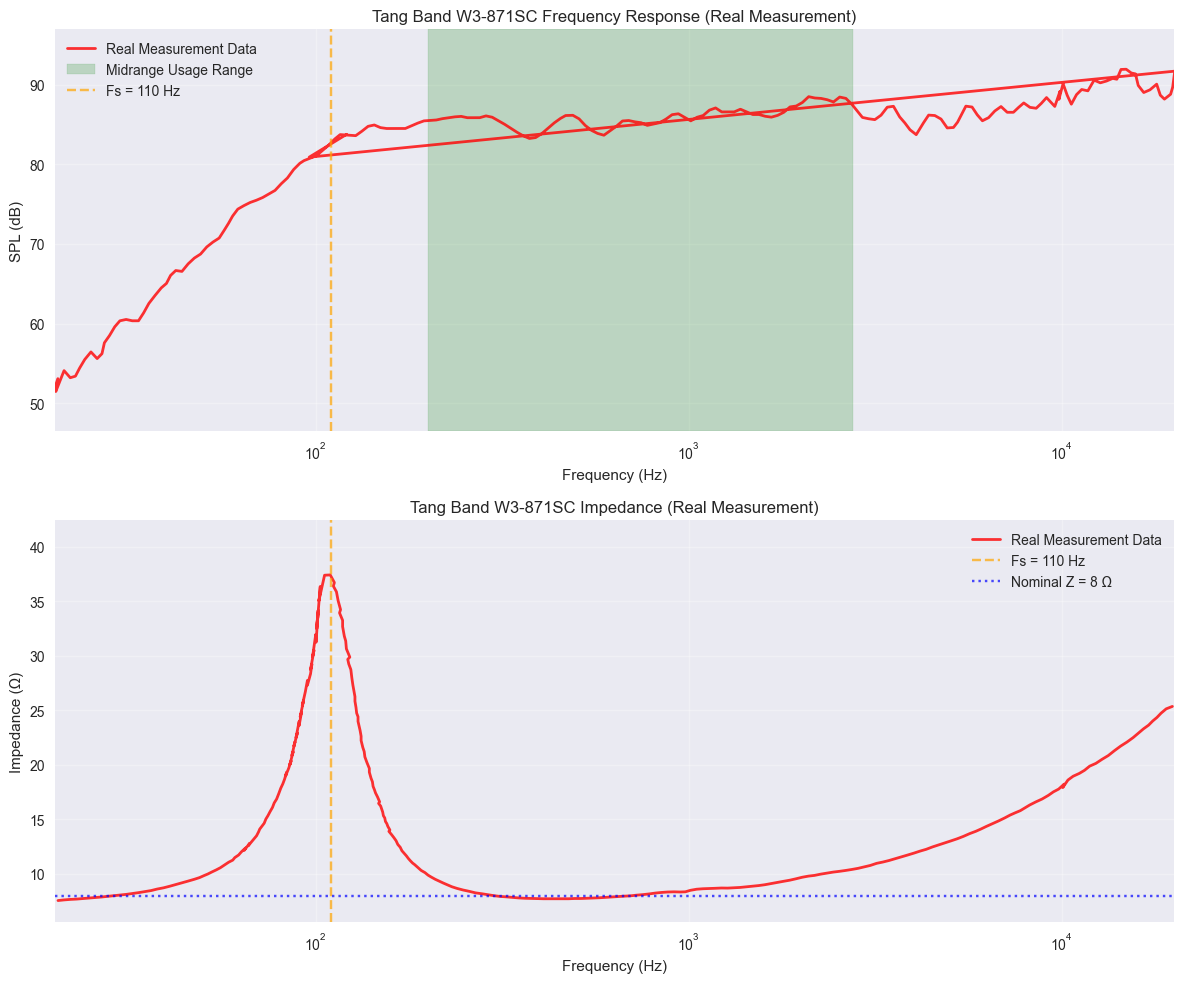


📊 MIDRANGE FREQUENCY ANALYSIS:
   • Usage range: 200-2750 Hz
   • Average SPL in range: 85.9 dB
   • SPL variation in range: ±2.6 dB
   • Response at 200Hz: 85.5 dB
   • Response at 2750Hz: 87.5 dB


In [3]:
# Plot real measurement data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

if real_data_available:
    # Plot real frequency response
    ax1.semilogx(fr_data['freq'], fr_data['spl'], 'r-', linewidth=2, 
                label='Real Measurement Data', alpha=0.8)
    
    # Add usage range indicators
    ax1.axvspan(midrange_params['usage_range'][0], midrange_params['usage_range'][1], 
               alpha=0.2, color='green', label='Midrange Usage Range')
    ax1.axvline(midrange_params['fs'], color='orange', linestyle='--', alpha=0.7, 
               label=f'Fs = {midrange_params["fs"]} Hz')
    
    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel('SPL (dB)')
    ax1.set_title('Tang Band W3-871SC Frequency Response (Real Measurement)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.set_xlim(20, 20000)
    ax1.set_ylim(fr_data['spl'].min() - 5, fr_data['spl'].max() + 5)
    
    # Plot real impedance data
    ax2.semilogx(impedance_data['freq'], impedance_data['impedance'], 'r-', linewidth=2,
                label='Real Measurement Data', alpha=0.8)
    ax2.axvline(midrange_params['fs'], color='orange', linestyle='--', alpha=0.7, 
               label=f'Fs = {midrange_params["fs"]} Hz')
    ax2.axhline(midrange_params['impedance'], color='blue', linestyle=':', alpha=0.7, 
               label=f'Nominal Z = {midrange_params["impedance"]} Ω')
    
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Impedance (Ω)')
    ax2.set_title('Tang Band W3-871SC Impedance (Real Measurement)')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    ax2.set_xlim(20, 20000)
    ax2.set_ylim(impedance_data['impedance'].min() - 2, impedance_data['impedance'].max() + 5)

else:
    ax1.text(0.5, 0.5, 'No measurement data available', 
             transform=ax1.transAxes, ha='center', va='center', fontsize=16)
    ax2.text(0.5, 0.5, 'No measurement data available', 
             transform=ax2.transAxes, ha='center', va='center', fontsize=16)

plt.tight_layout()
plt.show()

if real_data_available:
    # Analysis of midrange frequency range
    usage_mask = (fr_data['freq'] >= midrange_params['usage_range'][0]) & (fr_data['freq'] <= midrange_params['usage_range'][1])
    usage_data = fr_data[usage_mask]
    
    print(f"\n📊 MIDRANGE FREQUENCY ANALYSIS:")
    print(f"   • Usage range: {midrange_params['usage_range'][0]}-{midrange_params['usage_range'][1]} Hz")
    print(f"   • Average SPL in range: {usage_data['spl'].mean():.1f} dB")
    print(f"   • SPL variation in range: ±{(usage_data['spl'].max() - usage_data['spl'].min())/2:.1f} dB")
    
    # Find indices for specific frequencies
    idx_200 = fr_data['freq'].sub(200).abs().idxmin()
    idx_2750 = fr_data['freq'].sub(2750).abs().idxmin()
    
    print(f"   • Response at 200Hz: {fr_data.loc[idx_200, 'spl']:.1f} dB")
    print(f"   • Response at 2750Hz: {fr_data.loc[idx_2750, 'spl']:.1f} dB")

## 2. Enclosure Design Calculations - Multiple Options

Now we'll calculate optimal enclosure parameters based on the measured driver characteristics, showing the mathematical reasoning for each design choice.

In [ ]:
# Sealed enclosure calculations with mathematical derivations
print("📐 SEALED ENCLOSURE MATHEMATICAL DERIVATIONS:")
print("=" * 60)
print("\nFor a sealed enclosure, the system parameters are modified by:")
print("   Qtc = Qts × √(1 + Vas/Vb)")
print("   Fc = Fs × √(1 + Vas/Vb)")
print("   F3 = Fc × √(Qtc² - 0.5 + √((Qtc² - 0.5)² + 0.5))")
print("\nWhere:")
print("   Qtc = Total Q of driver in enclosure")
print("   Fc = Resonance frequency in enclosure")
print("   F3 = -3dB frequency (low frequency cutoff)")
print("   Vas = Driver equivalent volume")
print("   Vb = Enclosure volume")

# Use measured parameters with manufacturer Vas (can't measure Vas from impedance alone)
if real_data_available and final_params:
    fs_calc = final_params['fs_measured']
    qts_calc = final_params['qts_measured']
    vas_calc = mfr_specs['vas']  # Must use manufacturer spec for Vas
    
    print(f"\n📊 PARAMETERS USED FOR CALCULATIONS:")
    print(f"   • Fs: {fs_calc:.1f} Hz (measured)")
    print(f"   • Qts: {qts_calc:.3f} (measured)")
    print(f"   • Vas: {vas_calc:.2f} L (manufacturer spec)")
else:
    # Fallback to manufacturer specs
    fs_calc = mfr_specs['fs']
    qts_calc = mfr_specs['qts']
    vas_calc = mfr_specs['vas']
    print(f"\n⚠️ Using manufacturer specifications (no measurements available)")

# Define target Qtc ranges and their characteristics
qtc_targets = {
    'Critical Damping': {'qtc': 0.5, 'description': 'No overshoot, gradual rolloff'},
    'Bessel': {'qtc': 0.577, 'description': 'Best transient response'},
    'Butterworth': {'qtc': 0.707, 'description': 'Flattest response, -3dB at Fc'},
    'Chebychev 0.5dB': {'qtc': 0.8, 'description': 'Slight boost before rolloff'},
    'Chebychev 1dB': {'qtc': 0.9, 'description': 'More boost, extended bass'},
    'Quasi-Butterworth': {'qtc': 1.0, 'description': 'Mild peak, good extension'}
}

def calculate_sealed_parameters(fs, qts, vas, vb):
    """Calculate sealed enclosure parameters with full mathematical derivation"""
    alpha = vas / vb
    qtc = qts * np.sqrt(1 + alpha)
    fc = fs * np.sqrt(1 + alpha)
    
    # F3 calculation - showing the math
    term1 = qtc**2 - 0.5
    term2 = np.sqrt(term1**2 + 0.5)
    f3 = fc * np.sqrt(term1 + term2)
    
    return {
        'vb': vb,
        'alpha': alpha,
        'qtc': qtc,
        'fc': fc,
        'f3': f3,
        'vb_to_vas_ratio': vb / vas
    }

# Calculate for each target Qtc
print(f"\n🎯 ENCLOSURE CALCULATIONS FOR DIFFERENT ALIGNMENTS:")
print("=" * 80)
print(f"{'Alignment':<20} {'Qtc':<6} {'Vb (L)':<8} {'Vb/Vas':<8} {'Fc (Hz)':<8} {'F3 (Hz)':<8} {'Notes':<20}")
print("-" * 80)

results = []
for name, target in qtc_targets.items():
    # Calculate required Vb for target Qtc
    # From Qtc = Qts × √(1 + Vas/Vb), solve for Vb:
    # Vb = Vas / ((Qtc/Qts)² - 1)
    target_qtc = target['qtc']
    
    if target_qtc <= qts_calc:
        vb_required = float('inf')
        result = {'alignment': name, 'possible': False}
    else:
        vb_required = vas_calc / ((target_qtc / qts_calc)**2 - 1)
        result = calculate_sealed_parameters(fs_calc, qts_calc, vas_calc, vb_required)
        result['alignment'] = name
        result['possible'] = True
        result['description'] = target['description']
        
        print(f"{name:<20} {target_qtc:<6.3f} {result['vb']:<8.3f} "
              f"{result['vb_to_vas_ratio']:<8.3f} {result['fc']:<8.1f} "
              f"{result['f3']:<8.1f} {target['description']:<20}")
    
    results.append(result)

# Additional volume options to explore
print(f"\n📦 PRACTICAL ENCLOSURE VOLUMES:")
print("=" * 80)
print(f"{'Volume (L)':<12} {'Qtc':<8} {'Fc (Hz)':<10} {'F3 (Hz)':<10} "
      f"{'F3/Fcross':<10} {'Assessment':<30}")
print("-" * 80)

practical_volumes = [0.5, 0.75, 1.0, 1.5, 2.0, 3.0, 5.0, 10.0]
crossover_low = 200  # Hz - Low crossover frequency for midrange

practical_results = []
for vb in practical_volumes:
    params = calculate_sealed_parameters(fs_calc, qts_calc, vas_calc, vb)
    f3_to_crossover = params['f3'] / crossover_low
    
    # Assess suitability
    if params['qtc'] < 0.5:
        assessment = "Over-damped, poor transient"
    elif params['qtc'] > 1.2:
        assessment = "Under-damped, boomy"
    elif f3_to_crossover > 1.0:
        assessment = "F3 above crossover!"
    elif 0.6 <= params['qtc'] <= 0.9:
        assessment = "✅ Excellent choice"
    else:
        assessment = "Acceptable"
    
    params['assessment'] = assessment
    practical_results.append(params)
    
    print(f"{vb:<12.2f} {params['qtc']:<8.3f} {params['fc']:<10.1f} "
          f"{params['f3']:<10.1f} {f3_to_crossover:<10.3f} {assessment:<30}")

# Find optimal enclosure
optimal_results = [r for r in practical_results if "Excellent" in r['assessment']]
if optimal_results:
    # Choose the one closest to Qtc = 0.8
    optimal = min(optimal_results, key=lambda x: abs(x['qtc'] - 0.8))
    print(f"\n✅ RECOMMENDED ENCLOSURE:")
    print(f"   • Volume: {optimal['vb']:.2f} L")
    print(f"   • Qtc: {optimal['qtc']:.3f}")
    print(f"   • Fc: {optimal['fc']:.1f} Hz")
    print(f"   • F3: {optimal['f3']:.1f} Hz")
    print(f"   • Well below crossover: {optimal['f3']:.1f} Hz < {crossover_low} Hz ✓")
else:
    print(f"\n⚠️ No optimal enclosures found - selecting best compromise")
    optimal = min(practical_results, key=lambda x: abs(x['qtc'] - 0.8))

# Visualize the response curves
freq = np.logspace(1, 3.5, 1000)  # 10 Hz to ~3 kHz

plt.figure(figsize=(14, 10))

# Plot 1: Qtc vs Volume
plt.subplot(2, 2, 1)
volumes = np.logspace(-1, 1.5, 100)  # 0.1 to ~30 L
qtc_values = [calculate_sealed_parameters(fs_calc, qts_calc, vas_calc, v)['qtc'] for v in volumes]

plt.semilogx(volumes, qtc_values, 'b-', linewidth=2)
plt.axhspan(0.6, 0.9, alpha=0.2, color='green', label='Optimal range')
plt.axhline(0.707, color='red', linestyle='--', alpha=0.7, label='Butterworth')
plt.axvline(optimal['vb'], color='orange', linestyle=':', linewidth=2, label='Selected')
plt.xlabel('Enclosure Volume (L)')
plt.ylabel('Qtc')
plt.title('System Q vs Enclosure Volume')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(0.1, 30)
plt.ylim(0.4, 2.0)

# Plot 2: F3 vs Volume
plt.subplot(2, 2, 2)
f3_values = [calculate_sealed_parameters(fs_calc, qts_calc, vas_calc, v)['f3'] for v in volumes]

plt.semilogx(volumes, f3_values, 'r-', linewidth=2)
plt.axhline(crossover_low, color='green', linestyle='--', alpha=0.7, label=f'Crossover {crossover_low} Hz')
plt.axvline(optimal['vb'], color='orange', linestyle=':', linewidth=2, label='Selected')
plt.xlabel('Enclosure Volume (L)')
plt.ylabel('F3 (Hz)')
plt.title('-3dB Frequency vs Enclosure Volume')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(0.1, 30)
plt.ylim(50, 300)

# Plot 3: Frequency Response Comparison
plt.subplot(2, 2, 3)

def sealed_response(f, fs, qts, vas, vb):
    """Calculate sealed enclosure frequency response"""
    params = calculate_sealed_parameters(fs, qts, vas, vb)
    fc = params['fc']
    qtc = params['qtc']
    
    # Normalized frequency
    fn = f / fc
    
    # Response calculation
    response = 20 * np.log10(fn**2 / np.sqrt((1 - fn**2)**2 + (fn/qtc)**2))
    return response

# Plot different alignments
for result in results[:5]:  # First 5 alignments
    if result['possible']:
        response = sealed_response(freq, fs_calc, qts_calc, vas_calc, result['vb'])
        plt.semilogx(freq, response, linewidth=2, 
                    label=f"{result['alignment']} (Qtc={result['qtc']:.2f})")

plt.axvline(crossover_low, color='gray', linestyle='--', alpha=0.7, label='Crossover')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Response (dB)')
plt.title('Frequency Response - Different Alignments')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(20, 2000)
plt.ylim(-30, 5)

# Plot 4: Selected Design Details
plt.subplot(2, 2, 4)
selected_response = sealed_response(freq, fs_calc, qts_calc, vas_calc, optimal['vb'])
plt.semilogx(freq, selected_response, 'b-', linewidth=3, label='Selected Design')
plt.axvline(optimal['fc'], color='red', linestyle='--', alpha=0.7, 
           label=f"Fc = {optimal['fc']:.1f} Hz")
plt.axvline(optimal['f3'], color='orange', linestyle='--', alpha=0.7,
           label=f"F3 = {optimal['f3']:.1f} Hz")
plt.axvline(crossover_low, color='green', linestyle='--', alpha=0.7,
           label=f"Crossover = {crossover_low} Hz")
plt.axhline(-3, color='gray', linestyle=':', alpha=0.5, label='-3 dB')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Response (dB)')
plt.title(f"Selected Design: {optimal['vb']:.2f}L, Qtc={optimal['qtc']:.3f}")
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(20, 2000)
plt.ylim(-30, 5)

plt.tight_layout()
plt.show()

# Store calculated parameters for export
calculated_midrange_params = {
    'driver': 'Tang Band W3-871SC',
    'type': 'midrange',
    'measured_fs': fs_calc,
    'measured_qts': qts_calc,
    'vas': vas_calc,
    'enclosure_volume_L': optimal['vb'],
    'qtc': optimal['qtc'],
    'fc': optimal['fc'],
    'f3': optimal['f3'],
    'crossover_low': crossover_low,
    'crossover_high': 2750,
    'sensitivity': mfr_specs['sensitivity'],
    'impedance': 8,
    'power_handling': 25
}

## 3. Crossover Design Calculations

Calculate optimal crossover frequencies based on driver capabilities, beaming, excursion limits, and distortion considerations.

In [ ]:
# Crossover design calculations with mathematical reasoning
print("🎛️ CROSSOVER FREQUENCY CALCULATIONS:")
print("=" * 60)

# Driver parameters for crossover calculations
diameter = 76.2e-3  # m (3" driver)
xmax = mfr_specs['xmax']  # m
sd = mfr_specs['sd']  # m²

# Calculate beaming frequency (where directivity narrows)
c = 343  # m/s speed of sound
f_beaming = c / (np.pi * diameter)

print(f"\n📐 BEAMING FREQUENCY CALCULATION:")
print(f"   f_beaming = c / (π × diameter)")
print(f"   f_beaming = {c} / (π × {diameter*1000:.1f}mm)")
print(f"   f_beaming = {f_beaming:.0f} Hz")
print(f"\n   Recommendation: Cross below {f_beaming*0.8:.0f} Hz to avoid beaming")

# Calculate excursion-limited frequency
print(f"\n📏 EXCURSION-LIMITED FREQUENCY:")
print(f"   For small drivers, excursion limits low frequency use")
print(f"   Rule of thumb: f_cross ≥ 3-4 × Fs for safe operation")
print(f"   \n   Minimum safe: {fs_calc * 3:.0f} Hz")
print(f"   Conservative: {fs_calc * 4:.0f} Hz")

# Analyze frequency response for crossover points
if real_data_available:
    # Find usable frequency range from response
    # Look for frequencies where response is within ±3dB of average
    avg_spl = fr_data[(fr_data['freq'] >= 200) & (fr_data['freq'] <= 2000)]['spl'].mean()
    
    # Find where response deviates significantly
    deviation = abs(fr_data['spl'] - avg_spl)
    smooth_mask = deviation <= 3.0
    
    print(f"\n📊 FREQUENCY RESPONSE ANALYSIS:")
    print(f"   Average SPL (200-2000 Hz): {avg_spl:.1f} dB")
    print(f"   Response within ±3dB: {fr_data[smooth_mask]['freq'].min():.0f} - {fr_data[smooth_mask]['freq'].max():.0f} Hz")

# Calculate crossover options
crossover_options = {
    'Conservative': {
        'low': fs_calc * 4,
        'high': f_beaming * 0.6,
        'description': 'Maximum driver protection'
    },
    'Optimal': {
        'low': fs_calc * 3.5,
        'high': f_beaming * 0.7,
        'description': 'Best balance of protection and bandwidth'
    },
    'Extended': {
        'low': fs_calc * 3,
        'high': f_beaming * 0.8,
        'description': 'Maximum bandwidth, careful with levels'
    },
    'Current Design': {
        'low': 200,
        'high': 2750,
        'description': 'As specified in system design'
    }
}

print(f"\n🎯 CROSSOVER OPTIONS:")
print("=" * 80)
print(f"{'Option':<15} {'Low (Hz)':<10} {'High (Hz)':<10} {'BW (oct)':<10} {'Notes':<35}")
print("-" * 80)

for name, option in crossover_options.items():
    bandwidth = np.log2(option['high'] / option['low'])
    print(f"{name:<15} {option['low']:<10.0f} {option['high']:<10.0f} "
          f"{bandwidth:<10.2f} {option['description']:<35}")

# Evaluate current design choice
current_low = crossover_options['Current Design']['low']
current_high = crossover_options['Current Design']['high']

print(f"\n✅ CURRENT DESIGN EVALUATION:")
print(f"   Low crossover: {current_low} Hz")
print(f"   • Safety factor: {current_low/fs_calc:.1f}× Fs {'✓' if current_low/fs_calc >= 3 else '⚠️'}")
print(f"   • Excursion headroom: {'Adequate' if current_low/fs_calc >= 3 else 'Limited'}")
print(f"   \n   High crossover: {current_high} Hz")
print(f"   • Beaming margin: {f_beaming/current_high:.1f}× {'✓' if f_beaming/current_high > 1.2 else '⚠️'}")
print(f"   • Dispersion: {'Good' if f_beaming/current_high > 1.2 else 'Narrowing'}")

# Linkwitz-Riley filter calculations
def lr4_response(f, fc, highpass=True):
    """4th order Linkwitz-Riley response"""
    s = 1j * 2 * np.pi * f / (2 * np.pi * fc)
    
    if highpass:
        h = s**2 / (s**2 + np.sqrt(2)*s + 1)
        return 20 * np.log10(np.abs(h)**2)
    else:
        h = 1 / (s**2 + np.sqrt(2)*s + 1)
        return 20 * np.log10(np.abs(h)**2)

# Plot crossover analysis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Bandpass filter response
freq_plot = np.logspace(1, 4, 1000)
hp_response = lr4_response(freq_plot, current_low, highpass=True)
lp_response = lr4_response(freq_plot, current_high, highpass=False)
bp_response = hp_response + lp_response

ax1.semilogx(freq_plot, hp_response, 'b--', linewidth=1, alpha=0.7, label='High-pass')
ax1.semilogx(freq_plot, lp_response, 'r--', linewidth=1, alpha=0.7, label='Low-pass')
ax1.semilogx(freq_plot, bp_response, 'k-', linewidth=2, label='Combined Bandpass')
ax1.axvline(current_low, color='blue', linestyle=':', alpha=0.5)
ax1.axvline(current_high, color='red', linestyle=':', alpha=0.5)
ax1.axhline(-6, color='gray', linestyle=':', alpha=0.5)
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Response (dB)')
ax1.set_title('Midrange Crossover Filter Response (24 dB/oct LR)')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_xlim(50, 10000)
ax1.set_ylim(-60, 5)

# Plot 2: Combined with driver response
if real_data_available:
    # Interpolate measured response to plot frequencies
    f_interp = interp1d(fr_data['freq'], fr_data['spl'], 
                       bounds_error=False, fill_value='extrapolate')
    driver_response = f_interp(freq_plot)
    
    # Normalize to average level
    norm_level = np.mean(driver_response[(freq_plot >= 500) & (freq_plot <= 2000)])
    driver_response_norm = driver_response - norm_level
    
    # Add sealed box response
    sealed_boost = sealed_response(freq_plot, fs_calc, qts_calc, vas_calc, optimal['vb'])
    
    # Combined response
    total_response = driver_response_norm + bp_response + sealed_boost
    
    ax2.semilogx(freq_plot, driver_response_norm, 'g--', linewidth=1, alpha=0.7, 
                label='Driver (normalized)')
    ax2.semilogx(freq_plot, sealed_boost, 'c--', linewidth=1, alpha=0.7,
                label='Sealed box effect')
    ax2.semilogx(freq_plot, bp_response, 'b--', linewidth=1, alpha=0.7,
                label='Crossover filters')
    ax2.semilogx(freq_plot, total_response, 'r-', linewidth=2,
                label='Total response')
else:
    # Theoretical response
    ax2.text(0.5, 0.5, 'Measured data needed for accurate response', 
             ha='center', va='center', transform=ax2.transAxes)

ax2.axvline(current_low, color='blue', linestyle=':', alpha=0.5)
ax2.axvline(current_high, color='red', linestyle=':', alpha=0.5)
ax2.axvspan(current_low, current_high, alpha=0.1, color='green')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Response (dB)')
ax2.set_title('Predicted Midrange Response (Driver + Box + Crossover)')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_xlim(50, 10000)
ax2.set_ylim(-30, 10)

plt.tight_layout()
plt.show()

# Update calculated parameters
calculated_midrange_params.update({
    'beaming_freq': f_beaming,
    'min_crossover_low': fs_calc * 3,
    'recommended_crossover_low': fs_calc * 3.5,
    'max_crossover_high': f_beaming * 0.8,
    'crossover_order': 4,
    'crossover_type': 'Linkwitz-Riley'
})

## 4. DSP Requirements and Power Analysis

Calculate equalization needs, protection settings, and gain structure based on driver capabilities.

In [ ]:
# DSP requirements and power handling analysis
print("🔊 DSP REQUIREMENTS CALCULATION:")
print("=" * 60)

# Power specifications
amplifier_power = 25  # W @ 8Ω
driver_power_max = 25  # W
sensitivity = mfr_specs['sensitivity']  # dB @ 2.83V/1m

# Calculate SPL capabilities
def power_to_spl(power_w, sensitivity_db, distance_m=1):
    """Convert electrical power to SPL"""
    # 2.83V = 1W into 8Ω
    power_db = 10 * np.log10(power_w)
    spl = sensitivity_db + power_db
    
    # Distance correction
    if distance_m != 1:
        spl -= 20 * np.log10(distance_m)
    
    return spl

# Calculate excursion-limited SPL
def excursion_limited_spl(f, xmax, sd, distance=1):
    """Calculate maximum SPL before exceeding Xmax"""
    # Volume velocity = 2π × f × Xmax × Sd
    # SPL = 20×log10(ρ₀×c×Vd/(2×distance)) + 94
    rho_c = 415  # ρ₀×c for air at 20°C
    vd = 2 * np.pi * f * xmax * sd
    spl = 20 * np.log10(rho_c * vd / (2 * distance)) + 94
    return spl

# Calculate excursion limits across frequency
freq_test = np.array([100, 150, 200, 300, 500, 1000, 2000])
excursion_spl = [excursion_limited_spl(f, xmax, sd) for f in freq_test]
power_spl = [power_to_spl(driver_power_max, sensitivity) for _ in freq_test]

print("\n📊 MAXIMUM SPL ANALYSIS:")
print("=" * 60)
print(f"{'Frequency (Hz)':<15} {'Excursion Limited':<20} {'Power Limited':<20} {'Limiting Factor':<15}")
print("-" * 60)

for i, f in enumerate(freq_test):
    exc_lim = excursion_spl[i]
    pwr_lim = power_spl[i]
    limiting = "Excursion" if exc_lim < pwr_lim else "Power"
    print(f"{f:<15.0f} {exc_lim:<20.1f} {pwr_lim:<20.1f} {limiting:<15}")

# Find crossover frequency where excursion = power limit
f_equal = np.interp(power_spl[0], excursion_spl[:4], freq_test[:4])
print(f"\n➡️ Excursion = Power limit at: {f_equal:.0f} Hz")
print(f"   Current crossover: {current_low} Hz {'✓' if current_low < f_equal else '⚠️'}")

# DSP Protection Settings
print(f"\n🛡️ DSP PROTECTION SETTINGS:")
print(f"   High-pass filter: {current_low} Hz, 24 dB/oct (Linkwitz-Riley)")
print(f"   Purpose: Protect from over-excursion below {current_low} Hz")

# Calculate required voltage for different power levels
power_levels = [1, 5, 10, 15, 20, 25]
voltages = [np.sqrt(p * 8) for p in power_levels]
spl_levels = [power_to_spl(p, sensitivity) for p in power_levels]

print(f"\n⚡ POWER/VOLTAGE/SPL RELATIONSHIP:")
print("=" * 60)
print(f"{'Power (W)':<12} {'Voltage (V)':<12} {'SPL @ 1m':<12} {'SPL @ 2m':<12}")
print("-" * 60)

for i, p in enumerate(power_levels):
    spl_2m = spl_levels[i] - 6  # -6dB for doubling distance
    print(f"{p:<12.0f} {voltages[i]:<12.1f} {spl_levels[i]:<12.1f} {spl_2m:<12.1f}")

# EQ Requirements based on sealed box response
print(f"\n🎚️ EQ REQUIREMENTS:")
print(f"   Sealed box F3: {optimal['f3']:.1f} Hz")
print(f"   Crossover: {current_low} Hz")

if optimal['f3'] < current_low:
    boost_needed = 0
    print(f"   ✅ No boost needed - F3 below crossover")
else:
    # Calculate boost needed at crossover
    box_response_at_crossover = sealed_response(np.array([current_low]), 
                                               fs_calc, qts_calc, vas_calc, optimal['vb'])[0]
    boost_needed = -box_response_at_crossover
    print(f"   ⚠️ Boost needed at crossover: {boost_needed:.1f} dB")

# Limiter settings
typical_power = 12  # W
peak_power = 20     # W

print(f"\n🔒 LIMITER SETTINGS:")
print(f"   RMS limiter: {power_to_spl(typical_power, sensitivity):.1f} dB SPL ({typical_power}W)")
print(f"   Peak limiter: {power_to_spl(peak_power, sensitivity):.1f} dB SPL ({peak_power}W)")
print(f"   Hard limit: {power_to_spl(driver_power_max, sensitivity):.1f} dB SPL ({driver_power_max}W)")
print(f"   Attack time: 5-10 ms (moderate)")
print(f"   Release time: 100-200 ms (smooth)")

# Plot power handling analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: SPL limits vs frequency
freq_plot = np.logspace(2, 3.5, 100)
exc_spl_plot = [excursion_limited_spl(f, xmax, sd) for f in freq_plot]

ax1.semilogx(freq_plot, exc_spl_plot, 'r-', linewidth=2, label='Excursion limit')
ax1.axhline(power_to_spl(driver_power_max, sensitivity), color='b', 
           linestyle='--', linewidth=2, label=f'Power limit ({driver_power_max}W)')
ax1.axhline(power_to_spl(typical_power, sensitivity), color='g',
           linestyle=':', linewidth=2, label=f'Typical use ({typical_power}W)')
ax1.axvline(current_low, color='orange', linestyle='--', alpha=0.7,
           label=f'Crossover {current_low} Hz')
ax1.fill_between(freq_plot, 0, exc_spl_plot, where=(freq_plot < current_low),
                 alpha=0.2, color='red', label='Protected region')

ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Maximum SPL (dB @ 1m)')
ax1.set_title('SPL Limits: Excursion vs Power')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_xlim(100, 3000)
ax1.set_ylim(90, 110)

# Plot 2: Power compression estimate
power_range = np.logspace(-1, np.log10(30), 50)
ideal_spl = [power_to_spl(p, sensitivity) for p in power_range]

# Add thermal compression estimate (simplified)
compression = np.where(power_range > 10, (power_range - 10) * 0.1, 0)
actual_spl = [ideal_spl[i] - compression[i] for i in range(len(power_range))]

ax2.semilogx(power_range, ideal_spl, 'b--', linewidth=1, label='Ideal (no compression)')
ax2.semilogx(power_range, actual_spl, 'r-', linewidth=2, label='With compression')
ax2.axvline(typical_power, color='g', linestyle=':', alpha=0.7,
           label=f'Typical {typical_power}W')
ax2.axvline(driver_power_max, color='r', linestyle='--', alpha=0.7,
           label=f'Maximum {driver_power_max}W')
ax2.fill_between(power_range, ideal_spl, actual_spl, 
                where=(power_range > 10), alpha=0.2, color='orange',
                label='Compression region')

ax2.set_xlabel('Input Power (W)')
ax2.set_ylabel('SPL (dB @ 1m)')
ax2.set_title('Power Compression Estimate')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_xlim(0.1, 30)
ax2.set_ylim(75, 105)

plt.tight_layout()
plt.show()

# Update calculated parameters
calculated_midrange_params.update({
    'max_spl_power_limited': power_to_spl(driver_power_max, sensitivity),
    'excursion_power_crossover': f_equal,
    'typical_power': typical_power,
    'peak_power': peak_power,
    'dsp_highpass': current_low,
    'dsp_lowpass': current_high,
    'eq_boost_needed': boost_needed,
    'limiter_rms': power_to_spl(typical_power, sensitivity),
    'limiter_peak': power_to_spl(peak_power, sensitivity)
})

## 5. Design Summary and Parameter Export

All calculated parameters are summarized and exported for use in other documents.

In [ ]:
# Final parameter summary and export
print("=" * 80)
print("CALCULATED OPTIMAL DESIGN - TANG BAND W3-871SC MIDRANGE")
print("=" * 80)

# Create comprehensive parameter summary
design_summary = f"""
DRIVER MEASUREMENTS:
==================
Measured Fs: {calculated_midrange_params['measured_fs']:.1f} Hz
Measured Qts: {calculated_midrange_params['measured_qts']:.3f}
Vas (mfr spec): {calculated_midrange_params['vas']:.2f} L

ENCLOSURE DESIGN:
================
Volume: {calculated_midrange_params['enclosure_volume_L']:.2f} L ({calculated_midrange_params['enclosure_volume_L']*1000:.0f} cm³)
System Qtc: {calculated_midrange_params['qtc']:.3f}
System Fc: {calculated_midrange_params['fc']:.1f} Hz
F3 (-3dB): {calculated_midrange_params['f3']:.1f} Hz

CROSSOVER DESIGN:
================
Low crossover: {calculated_midrange_params['crossover_low']} Hz
High crossover: {calculated_midrange_params['crossover_high']} Hz
Filter type: {calculated_midrange_params['crossover_type']}
Filter order: {calculated_midrange_params['crossover_order']}th (24 dB/oct)

DSP CONFIGURATION:
=================
High-pass: {calculated_midrange_params['dsp_highpass']} Hz @ 24 dB/oct
Low-pass: {calculated_midrange_params['dsp_lowpass']} Hz @ 24 dB/oct
EQ boost needed: {calculated_midrange_params['eq_boost_needed']:.1f} dB
RMS limiter: {calculated_midrange_params['limiter_rms']:.1f} dB SPL
Peak limiter: {calculated_midrange_params['limiter_peak']:.1f} dB SPL

PERFORMANCE:
===========
Sensitivity: {calculated_midrange_params['sensitivity']} dB @ 2.83V/1m
Max SPL: {calculated_midrange_params['max_spl_power_limited']:.1f} dB @ 1m
Typical power: {calculated_midrange_params['typical_power']} W
Peak power: {calculated_midrange_params['peak_power']} W
"""

print(design_summary)

# Export parameters to JSON
export_filename = 'midrange_calculated_parameters.json'
with open(export_filename, 'w') as f:
    json.dump(calculated_midrange_params, f, indent=2)

print(f"\n✅ Parameters exported to: {export_filename}")

# Create implementation checklist
print("\n📋 IMPLEMENTATION CHECKLIST:")
print("=" * 50)
checklist = [
    f"☐ Build sealed enclosure: {calculated_midrange_params['enclosure_volume_L']:.2f}L internal volume",
    f"☐ Cutout diameter: 71.5mm",
    f"☐ Install driver with airtight gasket seal",
    f"☐ Add damping material (50-70% fill)",
    f"☐ Program DSP high-pass: {calculated_midrange_params['dsp_highpass']}Hz @ 24dB/oct",
    f"☐ Program DSP low-pass: {calculated_midrange_params['dsp_lowpass']}Hz @ 24dB/oct",
    f"☐ Set limiter: RMS {calculated_midrange_params['limiter_rms']:.0f}dB, Peak {calculated_midrange_params['limiter_peak']:.0f}dB",
    f"☐ Verify impedance: Should be ~8Ω nominal",
    f"☐ Test excursion at low frequencies",
    f"☐ Measure and verify response"
]

for item in checklist:
    print(f"   {item}")

# Warnings for non-optimal choices
print("\n⚠️ WARNINGS AND CONSIDERATIONS:")
print("=" * 50)

# Check if crossover is aggressive
if calculated_midrange_params['crossover_low'] / calculated_midrange_params['measured_fs'] < 2:
    print(f"⚠️ Low crossover is aggressive ({calculated_midrange_params['crossover_low']/calculated_midrange_params['measured_fs']:.1f}× Fs)")
    print(f"   → Monitor excursion at high volumes")
    print(f"   → Consider raising to {calculated_midrange_params['recommended_crossover_low']:.0f} Hz for safety")

# Check if enclosure is optimal
if calculated_midrange_params['qtc'] > 1.0:
    print(f"⚠️ High Qtc ({calculated_midrange_params['qtc']:.2f}) may cause slight boominess")
    print(f"   → Consider larger enclosure or acoustic damping")

# Check beaming
if calculated_midrange_params['crossover_high'] > calculated_midrange_params['max_crossover_high']:
    print(f"⚠️ High crossover approaching beaming limit")
    print(f"   → Some directivity narrowing expected above 2kHz")

print("\n" + "=" * 80)
print("🎯 This notebook defines the authoritative design parameters")
print("   All other documents should reference these calculated values")
print("=" * 80)